In [ ]:
2! pip install facenet-pytorch==2.5.2
! pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
import torch
import facenet_pytorch
import yaml
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ANSWER = {}

In [ ]:
device

'cuda'

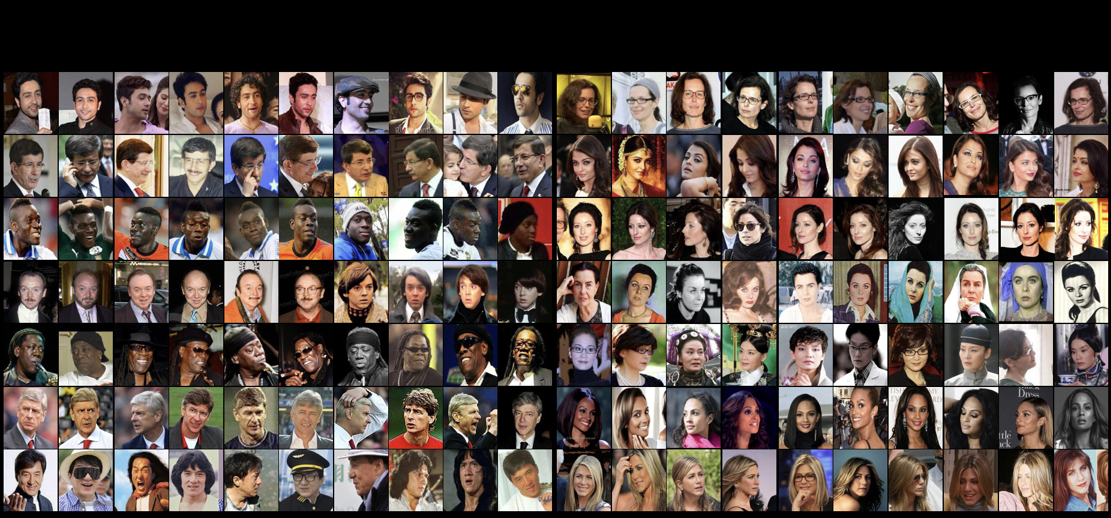

# HW 5. Face Recognition

На семинаре вы научились обучать metric learning модели. В домашнем задании мы применим полученные знания для задач распознавания лиц.

В задании предлагается использовать предобученную модель для распознавания лиц на датасете [VGGFace2](https://www.robots.ox.ac.uk/~vgg/data/vgg_face2/). Обучающая часть датасета состоит из ~3.3M изображений и ~9K личностей (классов). **Note:** обучаться на VGGFace2 в данном задании не требуется. В тестовой части 169396 картинок и 500 личностей, именно с ней будем работать. **Note:** множества классов на трейне и тесте не пересекаются, мы решаем open-set задачу.

**Для большинства заданий есть in-place тест, прохождения которого необходимо добиться перед отправкой задания в систему.**

Скачайте и распакуйте данные выполнив команды ниже:

In [ ]:
! gdown https://drive.google.com/uc?id=1kXofniu9Gpp54db0VpiKcJe5taBrAtBy
! gdown https://drive.google.com/uc?id=1kNlpJKmM1nnzJqzMruLrQdD6oCX5MeA6
! gdown https://drive.google.com/uc?id=1Sf8QbjZ6-w0Zbcc08_ICOKwVt_6LRX_F
! tar -zxvf  /content/vggface2.tar.gz

Выходные данные были обрезаны до нескольких последних строк (5000).
vggface2/048084.jpg
vggface2/093680.jpg
vggface2/082955.jpg
vggface2/114923.jpg
vggface2/068354.jpg
vggface2/152976.jpg
vggface2/077274.jpg
vggface2/058297.jpg
vggface2/135735.jpg
vggface2/031221.jpg
vggface2/102199.jpg
vggface2/060708.jpg
vggface2/122249.jpg
vggface2/078147.jpg
vggface2/037888.jpg
vggface2/083493.jpg
vggface2/103287.jpg
vggface2/050813.jpg
vggface2/016846.jpg
vggface2/059189.jpg
vggface2/028770.jpg
vggface2/007793.jpg
vggface2/165102.jpg
vggface2/079259.jpg
vggface2/093858.jpg
vggface2/027443.jpg
vggface2/123157.jpg
vggface2/061416.jpg
vggface2/038563.jpg
vggface2/017580.jpg
vggface2/066379.jpg
vggface2/124638.jpg
vggface2/113094.jpg
vggface2/071605.jpg
vggface2/133344.jpg
vggface2/037650.jpg
vggface2/009966.jpg
vggface2/026985.jpg
vggface2/038205.jpg
vggface2/144872.jpg
vggface2/085784.jpg
vggface2/094851.jpg
vggface2/102827.jpg
vggface2/133422.jpg
vggface2/071163.jpg
vggface2/037136.jpg
vggface2/030

## Задание 1. Подготовка данных и модели

Посмотрим на изображения в датасете:

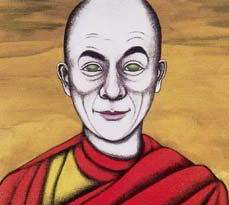

In [ ]:
Image.open("/content/vggface2/000296.jpg").convert("RGB")

### 1.1. Детектор (2 балла)

Датасет сырой: люди находятся в разных позах и сняты с разных ракурсов. Нам придётся использовать face detector перед передачей лиц в модель.

1. Ознакомьтесь с библиотекой https://github.com/timesler/facenet-pytorch и разберитесь, как использовать детектор лиц MTCNN. Возьмите MTCNN с дефолтными параметрами.
2. Реализуйте недостающие методы класса `VGGFace2Dataset`.
3. **Note:** Загружайте изображения при помощи PIL в формате RGB.
4. **Note:** Если детектор не находит лицо, то возвращайте тензор с нулями.
5. **Note:** Сделайте так, чтобы i-му элементу датасета соответствовала картинка `i.jpg`.

In [ ]:
from facenet_pytorch import MTCNN
import os
mtcnn = MTCNN(select_largest=False, device=device)

In [ ]:
class VGGFace2Dataset(torch.utils.data.Dataset):
    def __init__(self, root="/content/vggface2", transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(self.root, img_path) for img_path in sorted(os.listdir(self.root))]

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")
        tensor = mtcnn(image)
        if self.transform and tensor:
          tensor = self.transform(tensor)
        return tensor if tensor is not None else torch.zeros(3, 160, 160)

Для проверки детектируйте лицо на изображении `000000.jpg` и передайте полученный тензор в `write_answer_1_1`. 


In [ ]:
def write_answer_1_1(x):
    ANSWER["task11"] = {"answer": x.mean().item()}

def test_1_1(data):
    face = data[1]
    mean = face.mean().item()
    assert abs(mean - 0.04) < 1e-2

In [ ]:
from torchvision.transforms import transforms

In [ ]:
dataset = VGGFace2Dataset()

In [ ]:
test_1_1(dataset)

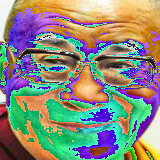

In [ ]:
tensor = dataset[1]
img = transforms.ToPILImage()(tensor)
display(img)


In [ ]:
write_answer_1_1(tensor)

### 1.2. Модель (1 балл)
Найдите в https://github.com/timesler/facenet-pytorch модель InceptionResnet, и загрузите её предобученную версию на датасете VGGFace2.

Для проверки вычислите эмбеддинг лица на изображении `000000.jpg` и передайте его в `write_answer_1_2`.

In [ ]:
def write_answer_1_2(x):
    ANSWER["task12"] = {"answer": x.mean().item()}

def test_1_2(model, data):
    embedding = model(torch.unsqueeze(data[1].to(device), 0))
    mean = embedding.mean().item()
    assert abs(mean - -0.0015) < 1e-3

In [ ]:
model = facenet_pytorch.InceptionResnetV1(pretrained='vggface2').eval().to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
test_1_2(model, dataset)

In [ ]:
img = dataset[0].unsqueeze(0).to(device)
emb = model(img)

In [ ]:


write_answer_1_2(emb)

## Задание 2. Выбираем функцию расстояния (1 балл)
Итак, у нас есть предобученная модель распознавания лиц. Для дальнейших действий нам нужно понять, какое расстояние использовать в пространстве эмбеддингов. Зная, что наша модель обучалась методом ArcFace, предположите, какая функция расстояния работает в пространстве эмбеддингов. Вычислите расстояние между лицами на изображениях `000000.jpg` и `000001.jpg` и передайте его в `write_answer_2`.


In [ ]:
def write_answer_2(x):
    ANSWER["task2"] = {"answer": x.item()}

def test_2(model, data, dist_func):
    e1 = model(torch.unsqueeze(data[2].to(device), 0))
    e2 = model(torch.unsqueeze(data[3].to(device), 0))
    dist = dist_func(e1, e2)
    assert abs(dist - 0.1873) < 1e-2

In [ ]:
def dist_func(x, y):
  return 1 - ((x @ y.T) / (torch.norm(x) * torch.norm(y)))

In [ ]:
test_2(model, dataset, dist_func)

In [ ]:
emb_0, emb_1 = model(dataset[0].unsqueeze(0).to(device)), model(dataset[1].unsqueeze(0).to(device))
dist = dist_func(emb_0, emb_1)
write_answer_2(dist)

## Задание 3. Face Identification (4 балла)

Теперь у нас есть всё, чтобы решить задачу Face Identification: по фотографии с лицом человека установить его личность. В `file2label.json` даны метки для 500 картинок (по 1 на каждый класс). Ваша задача - идентифицировать все лица в датасете. Передайте в `write_answer_3` тензор с предсказанными метками (i-й элемент - метка для картинки `i.jpg`.) Проверяющая система рассчитает accuracy и выставит балл. Для sanity check в `truelabels1000.json` даны истинные метки для первых 1000 картинок.

In [ ]:
import json
with open('file2label.json', 'r') as file:
  labels = json.load(file)

In [ ]:
import tqdm

with torch.no_grad():
  all_embs = []
  for img in tqdm.tqdm(dataset):
    all_embs.append(model(img.unsqueeze(0).to(device)))


100%|██████████| 169397/169397 [2:21:56<00:00, 19.89it/s]


In [ ]:
!pip install pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
import pickle as pkl

In [ ]:
def save(obj, filename):
    with open(filename, "wb") as outp:  
        pkl.dump(obj, outp)

def read(filename):
  with open(filename, "rb") as inp:
    return pkl.load(inp)

In [ ]:
save(all_embs, "embeddings_hw_08.pkl")

In [ ]:
embs_with_labels = []
for key in labels:
  ind = int(key[:-4])
  img = dataset[ind]
  with torch.no_grad():
    embs_with_labels.append(model(img.unsqueeze(0).to(device)))

In [ ]:
embs_with_labels = torch.stack(embs_with_labels).squeeze()
embs_with_labels.shape

torch.Size([500, 512])

In [ ]:
all_embs = torch.stack(all_embs).squeeze()

In [ ]:
!pip install torchmetrics
from torchmetrics.functional import pairwise_cosine_similarity
dist = 1 - pairwise_cosine_similarity(all_embs, embs_with_labels)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 32.0 MB/s 


In [ ]:
dist.shape

torch.Size([169397, 500])

In [ ]:
preds = dist.argmin(dim=-1)

In [ ]:
preds.shape

torch.Size([169397])

In [ ]:
with open("truelabels1000.json") as f:
  true_labels = json.load(f)

true = []
for key in true_labels:
  true.append(true_labels[key])

true_labels = torch.tensor(true)

(true_labels == preds[:1000].cpu()).sum() / 1000


tensor(0.5460)

In [ ]:
def write_answer_3(x):
    ANSWER["task3"] = {"answer": [int(l) for l in x]}

In [ ]:
write_answer_3(preds)

## Задание 4. Найти преподавателя (2 балла)

Самые внимательные могли заметить, что в датасете 169397 изображений, что на 1 больше анонсированного в самом начале. Дело в том, что в оригинальный датасет при загадочных обстоятельствах попала фотография преподавателя. Найдите её, применив все полученные ранее знания. Искать можно любым доступным способом, даже не самым честным, но лучше пользоваться вашими наработками с лекции, семинара и этого ДЗ. Передайте в `write_answer_4` номер фотографии в датасете.

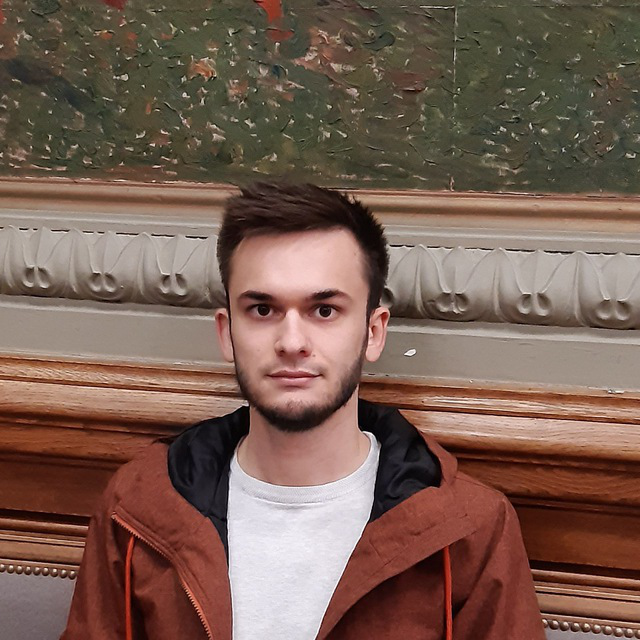

In [ ]:
prepod_photo_path = 'photo.jpeg'
prepod_photo = Image.open(prepod_photo_path).convert('RGB')
prepod_photo

In [ ]:
prepod_tensor = mtcnn(prepod_photo).to(device)
prepod_emb = model(prepod_tensor.unsqueeze(0)).to(device)

In [ ]:
prepod_dist = 1 - pairwise_cosine_similarity(prepod_emb, all_embs)

In [ ]:
prepod_idx = prepod_dist.argmin(dim=-1).item()

In [ ]:
img = transforms.ToPILImage()(dataset[prepod_idx])

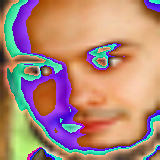

In [ ]:
img

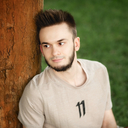

In [ ]:
img = Image.open(dataset.image_paths[prepod_idx]).convert('RGB')
img

Так это же Стас!)

In [ ]:
def write_answer_4(x):
    ANSWER["task4"] = {"answer": x}

In [ ]:
write_answer_4(prepod_idx)

## Запись submission

In [ ]:
submission = {"tasks": [{k: v} for k, v in ANSWER.items()]}
with open("submission.yaml", "w") as f:
    yaml.safe_dump(submission, f)